# LightGBM with all available features

## Set-up

In [1]:
import pickle
import os

import pandas as pd
import numpy as np
import shap
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('..')

In [3]:
from src.data.utils import load_datasets, COLUMN_DESCRIPTION_DICT
from src.models.utils import lgbm_feature_reduction

In [4]:
pd.options.display.max_columns = 50

## Load data

Now includes all features

In [5]:
RANDOM_SEED=42

In [6]:
%%time
train, dev, test, test_kaggle = load_datasets(random_seed=RANDOM_SEED)

Finished previous_application!
Finished installments_payments!
Finished pos_cash_balance!
Finished credit_card_balance!
CPU times: user 2min 32s, sys: 1min 21s, total: 3min 53s
Wall time: 4min 4s


In [7]:
train.shape

(184506, 1151)

## Fit basic model

In [8]:
import lightgbm

In [9]:
X_train = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_train = train['TARGET']

lgbm_basic = lightgbm.LGBMClassifier()

In [10]:
lgbm_basic.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [11]:
from sklearn.metrics import roc_auc_score

In [12]:
predictions = lgbm_basic.predict_proba(X_train)[:,1]

In [13]:
roc_auc_score(y_train, predictions)

0.8465813114462193

In [14]:
X_dev = dev.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_dev = dev['TARGET']

In [16]:
predictions = lgbm_basic.predict_proba(X_dev)[:,1]

In [17]:
roc_auc_score(y_dev, predictions)

0.7751461618970319

## Reduce features

In [22]:
output = lgbm_feature_reduction(
    lgbm_basic, X_train, y_train, X_dev, y_dev, num_rounds=20, prop_to_drop_each_round=0.03
)

2020-05-22 15:30:54,802 - Initial model: Training ROC AUC: 0.8465813114462193, Dev ROC AUC: 0.7751461618970319
2020-05-22 15:30:54,809 - Round 1 of feature dropping:

2020-05-22 15:30:54,905 - Number of features with importance below cutoff: 612
2020-05-22 15:31:17,114 - After 1 of dropping features: Training ROC AUC: 0.8465813114462193, Dev ROC AUC: 0.7751461618970319

2020-05-22 15:31:17,115 - Round 2 of feature dropping:

2020-05-22 15:31:17,150 - Number of features with importance below cutoff: 156
2020-05-22 15:31:32,905 - After 2 of dropping features: Training ROC AUC: 0.846316140057071, Dev ROC AUC: 0.7735040086508385

2020-05-22 15:31:32,907 - Round 3 of feature dropping:

2020-05-22 15:31:32,934 - Number of features with importance below cutoff: 41
2020-05-22 15:31:47,396 - After 3 of dropping features: Training ROC AUC: 0.8453979720227387, Dev ROC AUC: 0.7746133148181373

2020-05-22 15:31:47,397 - Round 4 of feature dropping:

2020-05-22 15:31:47,424 - Number of features with

(0.7, 0.8)

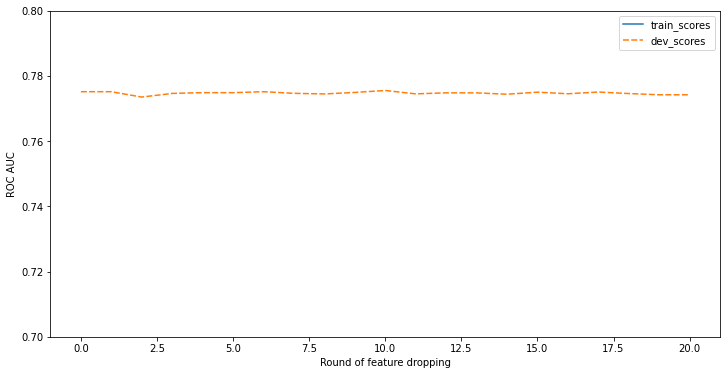

In [23]:
score_df = pd.DataFrame(
    {
        'train_scores': output['train_scores'],
        'dev_scores': output['dev_scores']
    }
)

plt.figure(figsize=(12,6))
plt.ylabel('ROC AUC')
plt.xlabel('Round of feature dropping')
sns.lineplot(data=score_df)

plt.ylim((0.7, 0.8))

In [26]:
score_df[score_df['dev_scores'] == score_df['dev_scores'].max()]

,train_scores,dev_scores
10,0.843985,0.775518


In [27]:
features_10 = output['features_after_round'][10]
len(features_10)

212

## Random search over LGBM hyperparameters using reduced set of features

In [29]:
from src.models.lgbm import fit_lgbm

In [30]:
train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,POS_CASH_balance_SK_DPD_amax_amin_y,POS_CASH_balance_SK_DPD_amax_amax_y,POS_CASH_balance_SK_DPD_DEF_mean_mean_y,POS_CASH_balance_SK_DPD_DEF_mean_sum_y,POS_CASH_balance_SK_DPD_DEF_mean_amin_y,POS_CASH_balance_SK_DPD_DEF_mean_amax_y,POS_CASH_balance_SK_DPD_DEF_sum_mean_y,POS_CASH_balance_SK_DPD_DEF_sum_sum_y,POS_CASH_balance_SK_DPD_DEF_sum_amin_y,POS_CASH_balance_SK_DPD_DEF_sum_amax_y,POS_CASH_balance_SK_DPD_DEF_amin_mean_y,POS_CASH_balance_SK_DPD_DEF_amin_sum_y,POS_CASH_balance_SK_DPD_DEF_amin_amin_y,POS_CASH_balance_SK_DPD_DEF_amin_amax_y,POS_CASH_balance_SK_DPD_DEF_amax_mean_y,POS_CASH_balance_SK_DPD_DEF_amax_sum_y,POS_CASH_balance_SK_DPD_DEF_amax_amin_y,POS_CASH_balance_SK_DPD_DEF_amax_amax_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Active_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Approved_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Completed_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Demand_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Refused,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Sent_proposal,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Signed_y
170657,297783,0.0,0,74250.0,112500.0,6282.0,112500.0,0.018850,-15077,-7915,-2853.0,-8,NaN,1,1,1,1,0,0,2.0,2,2,10,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0
251121,390572,0.0,2,225000.0,810000.0,40500.0,810000.0,0.035792,-14311,-1858,-2306.0,-5196,4.0,1,1,0,1,0,0,4.0,2,2,13,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96789,212363,0.0,0,225000.0,1546020.0,42642.0,1350000.0,0.032561,-15236,-5751,-7483.0,-4492,8.0,1,1,0,1,1,0,2.0,1,1,16,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0
14042,116368,1.0,1,202500.0,444420.0,30195.0,337500.0,0.018850,-17688,-754,-4307.0,-1243,22.0,1,1,0,1,0,0,3.0,2,2,14,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0
32597,137783,0.0,2,126000.0,1216201.5,35689.5,1062000.0,0.018029,-14030,-368,-3400.0,-4447,NaN,1,1,1,1,0,0,4.0,3,3,6,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
train_lgbm = train[['SK_ID_CURR', 'TARGET'] + features_10]
train_lgbm.shape

(184506, 214)

In [34]:
new_lgbm = fit_lgbm(train_data=train_lgbm)

dict_keys(['num_leaves', 'learning_rate', 'subsample_for_bin', 'min_child_samples', 'reg_alpha', 'reg_lambda', 'colsample_bytree', 'subsample'])
Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] subsample_for_bin=40000, subsample=0.6565656565656566, reg_lambda=2.927294835042816, reg_alpha=4.1173199311616795, num_leaves=94, min_child_samples=180, learning_rate=0.03765710082987185, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample_for_bin=40000, subsample=0.6565656565656566, reg_lambda=2.927294835042816, reg_alpha=4.1173199311616795, num_leaves=94, min_child_samples=180, learning_rate=0.03765710082987185, colsample_bytree=0.6, score=0.766, total=   8.5s
[CV] subsample_for_bin=40000, subsample=0.6565656565656566, reg_lambda=2.927294835042816, reg_alpha=4.1173199311616795, num_leaves=94, min_child_samples=180, learning_rate=0.03765710082987185, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV]  subsample_for_bin=40000, subsample=0.6565656565656566, reg_lambda=2.927294835042816, reg_alpha=4.1173199311616795, num_leaves=94, min_child_samples=180, learning_rate=0.03765710082987185, colsample_bytree=0.6, score=0.777, total=   8.9s
[CV] subsample_for_bin=40000, subsample=0.6565656565656566, reg_lambda=2.927294835042816, reg_alpha=4.1173199311616795, num_leaves=94, min_child_samples=180, learning_rate=0.03765710082987185, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.4s remaining:    0.0s


[CV]  subsample_for_bin=40000, subsample=0.6565656565656566, reg_lambda=2.927294835042816, reg_alpha=4.1173199311616795, num_leaves=94, min_child_samples=180, learning_rate=0.03765710082987185, colsample_bytree=0.6, score=0.780, total=   8.3s
[CV] subsample_for_bin=40000, subsample=0.6565656565656566, reg_lambda=2.927294835042816, reg_alpha=4.1173199311616795, num_leaves=94, min_child_samples=180, learning_rate=0.03765710082987185, colsample_bytree=0.6 
[CV]  subsample_for_bin=40000, subsample=0.6565656565656566, reg_lambda=2.927294835042816, reg_alpha=4.1173199311616795, num_leaves=94, min_child_samples=180, learning_rate=0.03765710082987185, colsample_bytree=0.6, score=0.781, total=   8.5s
[CV] subsample_for_bin=40000, subsample=0.6565656565656566, reg_lambda=2.927294835042816, reg_alpha=4.1173199311616795, num_leaves=94, min_child_samples=180, learning_rate=0.03765710082987185, colsample_bytree=0.6 
[CV]  subsample_for_bin=40000, subsample=0.6565656565656566, reg_lambda=2.9272948350

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 58.4min finished


In [35]:
new_lgbm.best_params_

{'subsample_for_bin': 200000,
 'subsample': 0.5757575757575758,
 'reg_lambda': 15.388177500383463,
 'reg_alpha': 17.188391428171457,
 'num_leaves': 26,
 'min_child_samples': 175,
 'learning_rate': 0.12312929581752732,
 'colsample_bytree': 0.6444444444444444}

In [36]:
new_lgbm.best_score_

0.7809554450455519

In [44]:
pickle.dump(new_lgbm, open('models/lgbm_all_features_reduced_random.pickle', 'wb'))

In [45]:
# test = pickle.load(open('models/lgbm_all_features_reduced_random.pickle', 'rb'))

## Make submission

In [37]:
test_kaggle.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,POS_CASH_balance_SK_DPD_amax_amin_y,POS_CASH_balance_SK_DPD_amax_amax_y,POS_CASH_balance_SK_DPD_DEF_mean_mean_y,POS_CASH_balance_SK_DPD_DEF_mean_sum_y,POS_CASH_balance_SK_DPD_DEF_mean_amin_y,POS_CASH_balance_SK_DPD_DEF_mean_amax_y,POS_CASH_balance_SK_DPD_DEF_sum_mean_y,POS_CASH_balance_SK_DPD_DEF_sum_sum_y,POS_CASH_balance_SK_DPD_DEF_sum_amin_y,POS_CASH_balance_SK_DPD_DEF_sum_amax_y,POS_CASH_balance_SK_DPD_DEF_amin_mean_y,POS_CASH_balance_SK_DPD_DEF_amin_sum_y,POS_CASH_balance_SK_DPD_DEF_amin_amin_y,POS_CASH_balance_SK_DPD_DEF_amin_amax_y,POS_CASH_balance_SK_DPD_DEF_amax_mean_y,POS_CASH_balance_SK_DPD_DEF_amax_sum_y,POS_CASH_balance_SK_DPD_DEF_amax_amin_y,POS_CASH_balance_SK_DPD_DEF_amax_amax_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Active_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Approved_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Completed_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Demand_y,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Refused,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Sent_proposal,POS_CASH_balance_COUNT_COUNT_NAME_CONTRACT_STATUS_Signed_y
307511,100001,NaN,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,2.0,2,2,18,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307512,100005,NaN,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,2.0,2,2,9,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307513,100013,NaN,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,2.0,2,2,14,0,0,...,1.0,1.0,0.010417,0.010417,0.010417,0.010417,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0
307514,100028,NaN,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,4.0,2,2,11,0,0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0
307515,100038,NaN,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,3.0,2,2,5,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
predictions = new_lgbm.predict_proba(test_kaggle[features_10])[:,1]

In [41]:
test_kaggle['TARGET'] = predictions

In [42]:
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('data/processed/all_features_random_search_submission.csv', index=False)

In [43]:
!kaggle competitions submit -c home-credit-default-risk -f data/processed/all_features_random_search_submission.csv -m "Full features"

100%|███████████████████████████████████████| 1.26M/1.26M [00:07<00:00, 168kB/s]
Successfully submitted to Home Credit Default Risk

Public score: 0.77467

Private score: 0.77374

Best performance so far.

Next steps:
- Further jumps in performance are likely to require further feature engineering. The aggregations made were very crude and may not have been appropriate for all features.
- Instead we will experiment with a neural network using the same dataset and more efficient hyperparameter search.